# Glacier speed inset plot

In [2]:
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pyproj
import pandas as pd
from pyproj import Proj, transform
from pyproj import Transformer
import matplotlib.patheffects as pe
import sys
sys.path.append("../data/velocity/")
import datacube_tools

## Load background image

In [3]:
with rio.open("./data/composite.tif", mode="r") as ds:
    img = ds.read([1,2,3])
    left, bottom, right, top = ds.bounds
    xfrm = ds.transform
    crs = ds.crs

img = np.moveaxis(img, 0, -1)

## Download velocity points

In [4]:
def build_mask(dcube, sat_filt, start_date, stop_date, baseline_mask):
    """
    Build velocity mask for inversion based on NaNs, satellite choices, and a date range

    Parameters
    ----------
    dcube - velocity datecube
    sat_filt - list of satellites to use
    start_date - start date for inversion
    stop_date - stop date for inversion
    baseline_mask - tuple specifying high and low baseline bounds in integer days

    Returns
    ------
    mask - Boolean mask for time axis of velocity datacube
    """
    # Remove all-nan timesteps, use vx
    if len(dcube.vx.shape) == 3:
        # supress stupid nanmean warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mask = np.logical_not(
                np.isnan(np.nanmean(np.nanmean(dcube.vx, axis=1), axis=1))
            )
    elif len(dcube.vx.shape) == 1:
        mask = np.logical_not(np.isnan(dcube.vx))

    # Satellite filter
    if sat_filt is not None:
        mask = np.logical_and(
            mask,
            np.logical_and(
                np.in1d(dcube.satellite_img1, sat_filt),
                np.in1d(dcube.satellite_img2, sat_filt),
            ),
        )

    # Start date filter
    if start_date is not None:
        tstart = np.datetime64(start_date)
        mask = np.logical_and(mask, dcube.acquisition_date_img1 >= tstart)

    # Stop date filter
    if stop_date is not None:
        tstop = np.datetime64(stop_date)
        mask = np.logical_and(mask, dcube.acquisition_date_img2 <= tstop)

    # Baseline filter
    baseline = (dcube.acquisition_date_img2 - dcube.acquisition_date_img1).dt.days
    
    if(baseline_mask[0] is not None):
        mask = np.logical_and(mask, baseline > baseline_mask[0])

    if(baseline_mask[1] is not None):
        mask = np.logical_and(mask, baseline < baseline_mask[1])
    
    return mask


In [16]:
# #Previous points, don't need them 

# xv = [587500, 583500, 587500, 592500, 594200]
# yv = [6662000, 6653000, 6656000, 6659000, 6665000]

# xform = pyproj.Transformer.from_crs(crs, "3413")
# xvp, yvp = xform.transform(xv, yv)

# pointvs = []
# pointts = []

# #sat_filt=["1A", "1B"]
# sat_filt = ["1A", "1B", "2A", "2B", "4", "5", "7", "8", "9"]
# start_date="2019-10-01"
# stop_date="2022-10-01"
# baseline_mask = (4, 100)

# for i in range(len(xv)):
#     # Download point date
#     dc = datacube_tools.DATACUBETOOLS()
#     xfull, xpnt, xy = dc.get_timeseries_at_point(
#         (xvp[i], yvp[i]),
#         "3413",
#         variables=[
#             "vx",
#             "vy",
#             "satellite_img1",
#             "satellite_img2",
#             "acquisition_date_img1",
#             "acquisition_date_img2",
#         ],
#     )

#     xpnt = xpnt.sortby("mid_date")

#     # Build mask
#     mask = build_mask(xpnt, sat_filt, start_date, stop_date, baseline_mask)
    
#     # Apply mask to velocity grid
#     vx_mask = xpnt["vx"][mask].to_numpy()[:, np.newaxis, np.newaxis]
#     vy_mask = xpnt["vy"][mask].to_numpy()[:, np.newaxis, np.newaxis]

#     pointvs.append(np.sqrt(vx_mask**2 + vy_mask**2)[:,0,0])
#     pointts.append(xpnt.mid_date[mask].to_numpy())

In [22]:
# get points from flowline 

points = pd.read_csv("./basemap/get_flowline/flowline_5.csv")

# xvp = [points.x[0].tonumpy(), points.x[15], points.x[30], points.x[45]] 
# yvp = [points.y[0], points.y[15], points.y[30], points.y[45]] 

xvp = points.x[[0, 14, 31, 45]].to_numpy()
yvp = points.y[[0, 14, 31, 45]].to_numpy()

xform = pyproj.Transformer.from_crs("3413", "32607")
xv, yv = xform.transform(xvp, yvp)


pointvs = []
pointts = []

#sat_filt=["1A", "1B"]
sat_filt = ["1A", "1B", "2A", "2B", "4", "5", "7", "8", "9"]
start_date="2019-10-01"
stop_date="2022-10-01"
baseline_mask = (4, 100)

for i in range(len(xvp)):
    # Download point date
    dc = datacube_tools.DATACUBETOOLS()
    xfull, xpnt, xy = dc.get_timeseries_at_point(
        (xvp[i], yvp[i]),
        "3413",
        variables=[
            "vx",
            "vy",
            "satellite_img1",
            "satellite_img2",
            "acquisition_date_img1",
            "acquisition_date_img2",
        ],
    )

    xpnt = xpnt.sortby("mid_date")

    # Build mask
    mask = build_mask(xpnt, sat_filt, start_date, stop_date, baseline_mask)
    
    # Apply mask to velocity grid
    vx_mask = xpnt["vx"][mask].to_numpy()[:, np.newaxis, np.newaxis]
    vy_mask = xpnt["vy"][mask].to_numpy()[:, np.newaxis, np.newaxis]

    pointvs.append(np.sqrt(vx_mask**2 + vy_mask**2)[:,0,0])
    pointts.append(xpnt.mid_date[mask].to_numpy())

original xy (np.float64(-3300747.2069313936), np.float64(248358.23367650664)) 3413 maps to datacube (np.float64(-3300747.2069313936), np.float64(248358.23367650664)) EPSG:3413


/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/../data/velocity/datacube_tools.py:286: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ins3xr = xr.open_dataset(
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:33: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img1, sat_filt),
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:34: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img2, sat_filt),


original xy (np.float64(-3306973.8800375615), np.float64(250413.32742814827)) 3413 maps to datacube (np.float64(-3306973.8800375615), np.float64(250413.32742814827)) EPSG:3413


/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/../data/velocity/datacube_tools.py:286: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ins3xr = xr.open_dataset(
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:33: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img1, sat_filt),
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:34: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img2, sat_filt),


original xy (np.float64(-3308940.7035095654), np.float64(256310.1248916983)) 3413 maps to datacube (np.float64(-3308940.7035095654), np.float64(256310.1248916983)) EPSG:3413


/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/../data/velocity/datacube_tools.py:286: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ins3xr = xr.open_dataset(
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:33: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img1, sat_filt),
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:34: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img2, sat_filt),


original xy (np.float64(-3311682.5019032466), np.float64(260347.90875685032)) 3413 maps to datacube (np.float64(-3311682.5019032466), np.float64(260347.90875685032)) EPSG:3413


/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/../data/velocity/datacube_tools.py:286: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ins3xr = xr.open_dataset(
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:33: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img1, sat_filt),
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_44503/4290604203.py:34: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(dcube.satellite_img2, sat_filt),


## Make figure

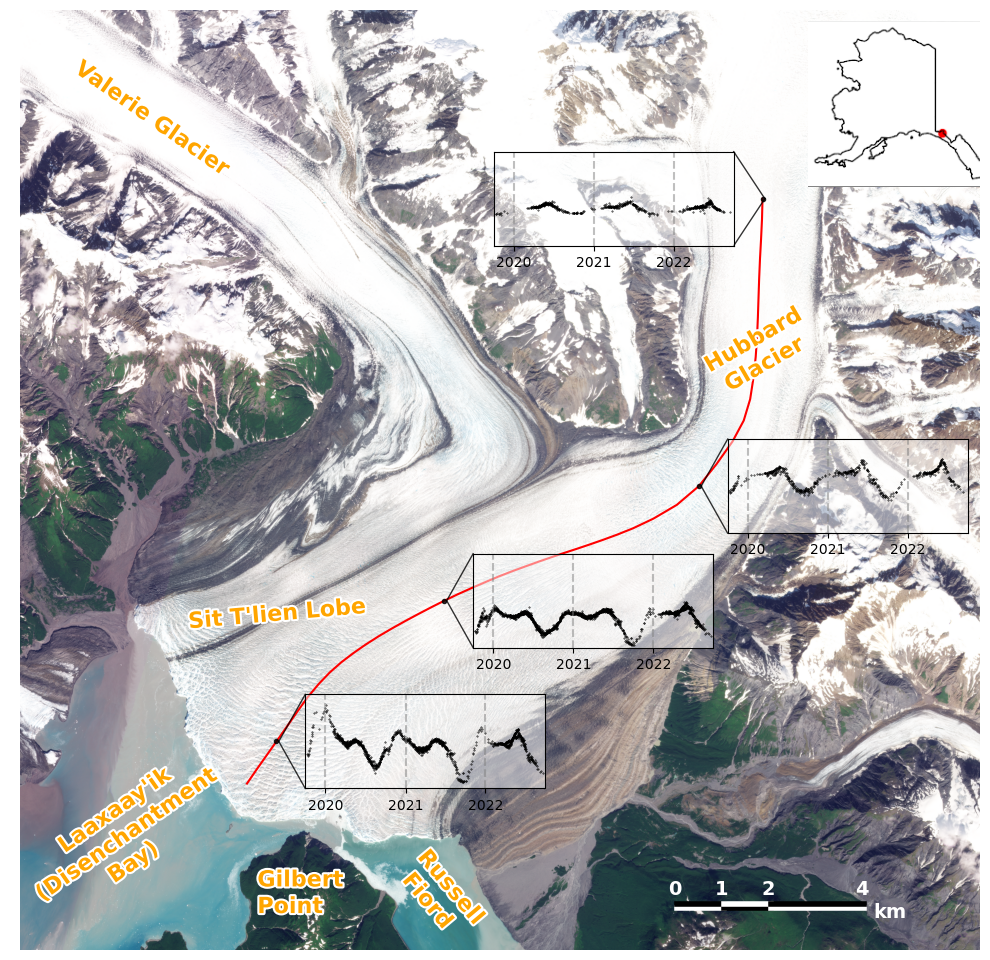

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), tight_layout=True)

# Plot basemap
ax.imshow(img, extent=[left, right, bottom, top])

# 1:1 aspect ratio
ax.set_aspect(1)

# Remove axis labels
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

# Add border
ax.patch.set_edgecolor("black")
ax.patch.set_linewidth(5)

# Shrink extents to remove basemap edges
shrink = 1e3
ax.set(xlim=(left+shrink, right-shrink), ylim=(bottom+shrink, top-shrink))


# add flowline
xform = pyproj.Transformer.from_crs("3413", "32607")
x, y = xform.transform(points.x, points.y)
ax.plot(x, y, "r")

# Add scale bar

# Add velocity insets
axis_to_data = ax.transAxes + ax.transData.inverted()
data_to_axis = axis_to_data.inverted()
dx = [-0.28, 0.03, 0.03, 0.03, -0.28]
for i in range(len(xv)):
    # Plot sample point
    plt.plot(xv[i], yv[i], 'k.', alpha=0.8)

    # Get axis coordinate for data points
    xa, ya = data_to_axis.transform([xv[i], yv[i]])
    axi = ax.inset_axes([xa+dx[i], ya-0.05, 0.25, 0.1])
    #axi = ax.inset_axes([1.05, ya-0.05, 0.25, 0.1])

    if(i in [0, 4]):
        xi0, yi0 = axis_to_data.transform([xa+dx[i]+0.25, ya-0.05])
        xi1, yi1 = axis_to_data.transform([xa+dx[i]+0.25, ya+0.05])
    else:
        xi0, yi0 = axis_to_data.transform([xa+dx[i], ya-0.05])
        xi1, yi1 = axis_to_data.transform([xa+dx[i], ya+0.05])
    #xi, yi = axis_to_data.transform([1.05, ya])
    ax.plot([xv[i]+50, xi0], [yv[i], yi0], 'k-', alpha=0.8, linewidth=1)
    ax.plot([xv[i]+50, xi1], [yv[i], yi1], 'k-', alpha=0.8, linewidth=1)

    # unit conversion
    ufac = 365
    
    # Turn off axis labels
    #axi.get_xaxis().set_visible(False)
    axi.get_xaxis().set_ticks([np.datetime64("2020-01-01"), np.datetime64("2021-01-01"), np.datetime64("2022-01-01")])
    axi.get_xaxis().set_ticklabels(['2020', '2021', '2022'])
    if(i != 4):
        axi.get_yaxis().set_visible(False)
    else:
        axi.get_yaxis().set_ticks([0, 8*ufac, 16*ufac])
        axi.get_yaxis().set_ticklabels([0, 8, 16])
        axi.get_yaxis().set_label_position("right")
        axi.get_yaxis().tick_right()
        axi.get_yaxis().set_label_text(r'm d$^{-1}$')
    
    # Make background transparent
    axi.patch.set_facecolor("white")
    axi.patch.set_alpha(0.5)

    # Plot velocity
    #axi.plot(ds.time, vts[i], "r-", linewidth=0.75)
    axi.plot(pointts[i], pointvs[i], "k.", markersize=0.75)
    axi.axvline(np.datetime64("2020-01-01"), color="grey", linestyle="dashed", alpha=0.5)
    axi.axvline(np.datetime64("2021-01-01"), color="grey", linestyle="dashed", alpha=0.5)
    axi.axvline(np.datetime64("2022-01-01"), color="grey", linestyle="dashed", alpha=0.5)
    axi.set_xlim(np.datetime64("2019-10"), np.datetime64("2022-10"))
    axi.set_ylim(0, 16*ufac)
    
# add inset
inset = plt.imread('./basemap/AKinset.png')
ax.imshow(inset, extent=[595300, 599300, 6665460, 6669000] )
    
# add a scale bar
ax.plot([592500, 593500], [6650000, 6650000], 'w', linewidth=4)
ax.plot([593500, 594500], [6650000, 6650000], 'k', linewidth=4)
ax.plot([594500, 596500], [6650000, 6650000], 'w', linewidth=4)
ax.plot([592500, 593500], [6650100, 6650100], 'k', linewidth=4)
ax.plot([593500, 594500], [6650100, 6650100], 'w', linewidth=4)
ax.plot([594500, 596500], [6650100, 6650100], 'k', linewidth=4)

ax.text(592300, 6650300, '0', fontsize=14, color='w', fontweight='bold')
ax.text(593300, 6650300, '1', fontsize=14, color='w', fontweight='bold')
ax.text(594300, 6650300, '2', fontsize=14, color='w', fontweight='bold')
ax.text(596300, 6650300, '4', fontsize=14, color='w', fontweight='bold')
ax.text(596700, 6649800, 'km', fontsize=14, color='w', fontweight='bold')

# add annotations
# ax.text(579500, 6665700, 'Valerie Glacier', rotation=-35, fontsize=16, fontweight='bold', color='orange')
# ax.text(593000, 6661000, 'Hubbard \n Glacier', rotation=30, fontsize=16, fontweight='bold', color='orange')
# ax.text(578200, 6649600, '       Laaxaay\'ik\n (Disenchantment\n          Bay)', rotation=35, fontsize=16, fontweight='bold', color='orange')
# ax.text(586400, 6649300, 'Russell\n Fiord', rotation=-50, fontsize=16, fontweight='bold', color='orange')
# ax.text(583500, 6649900, 'Gilbert\nPoint', fontsize=16, fontweight='bold', color='orange')
# ax.text(583500, 6657000, 'Sit T\'lien Lobe', fontsize=16, rotation=5, fontweight='bold', color='orange')

halo = [pe.Stroke(linewidth=3, foreground='white'), pe.Normal()]

ax.text(579500, 6665700, 'Valerie Glacier',
        rotation=-35, fontsize=16, fontweight='bold', color='orange',
        path_effects=halo)

ax.text(593000, 6661000, 'Hubbard \n Glacier',
        rotation=30, fontsize=16, fontweight='bold', color='orange',
        path_effects=halo)

ax.text(578200, 6649600, "       Laaxaay'ik\n (Disenchantment\n          Bay)",
        rotation=35, fontsize=16, fontweight='bold', color='orange',
        path_effects=halo)

ax.text(586400, 6649300, 'Russell\n Fiord',
        rotation=-50, fontsize=16, fontweight='bold', color='orange',
        path_effects=halo)

ax.text(583500, 6649900, 'Gilbert\nPoint',
        fontsize=16, fontweight='bold', color='orange',
        path_effects=halo)

ax.text(582000, 6656000, "Sit T'lien Lobe",
        fontsize=16, rotation=5, fontweight='bold', color='orange',
        path_effects=halo)

ax.axis('off')

fig.savefig("hubbard_map_with_velocities.png", dpi=300, bbox_inches="tight")

In [10]:
xv = [587500, 583500, 587500, 592500, 594200]
yv = [6662000, 6653000, 6656000, 6659000, 6665000]

xform = pyproj.Transformer.from_crs(crs, "3413")

xvp, yvp = xform.transform(xv, yv)

vts = []
for x, y in zip(xvp, yvp):
    # Get pixel x y
    px = np.argmin(np.abs(ds.x.to_numpy()-x))
    py = np.argmin(np.abs(ds.y.to_numpy()-y))
    vts.append(ds.v[:, py, px])
    plt.figure()
    plt.plot(ds.time, ds.v[:, py, px])
    plt.xlim(np.datetime64("2019"), np.datetime64("2022"))
    plt.ylim(0, 6e3)

NameError: name 'dc' is not defined